In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
files = ["Monday-WorkingHours.pcap_ISCX.csv", #0
         "Tuesday-WorkingHours.pcap_ISCX.csv", #1
         "Wednesday-workingHours.pcap_ISCX.csv", #2
         "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", #3
         "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", #4
         "Friday-WorkingHours-Morning.pcap_ISCX.csv", #5
         "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", #6
         "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"] #7

def dataset_file_to_df(index: int, dataset_files: list):
    read_file = f"../app/datasets/CSVs/{dataset_files[index]}"

    df_read = pd.read_csv(read_file)
    pattern = r'[^\w\s]'
    df_read['Label'] = df_read['Label'].replace(pattern, '', regex=True)
    df_read.replace([np.inf, -np.inf, np.nan], 1e10, inplace=True)

    return df_read

df = dataset_file_to_df(6, files)


In [3]:
def normalize(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df_norm = df.copy()
    for col in numeric_columns:
        if df[col].skew() > 0 or col == "Src Port":
            df_norm[col] = np.log1p(df[col].clip(lower=-0.99))  # Ensures log1p always gets valid input
        elif df[col].skew() < 0:
            df_norm[col] = df[col] ** 2  # Can cause overflow
    return df_norm

df_norm = normalize(df)

In [4]:
X = df_norm.drop(["Flow ID", "Src IP", "Timestamp", "Dst IP", "Label"], axis=1)
y = df_norm["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

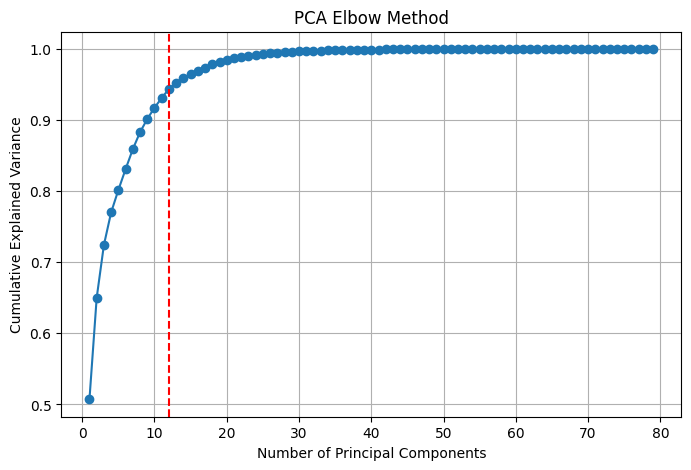

Optimal number of components: 12


In [6]:
pca = PCA()

pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Find the elbow point (where variance gain is <1%)
elbow_point = np.argmax(np.diff(cumulative_variance) < 0.01) + 1

plt.axvline(x=elbow_point, color='r', linestyle="--")  # Mark elbow
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Elbow Method")
plt.grid()
plt.show()

print(f"Optimal number of components: {elbow_point}")

In [7]:
pca = PCA(n_components=elbow_point)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Linear SVC

Training Time: 0.3500 seconds
Prediction Time: 0.0019 seconds
Total Time: 0.3519 seconds
Accuracy: 0.9987433239082626
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38297
           1       1.00      1.00      1.00     47644

    accuracy                           1.00     85941
   macro avg       1.00      1.00      1.00     85941
weighted avg       1.00      1.00      1.00     85941



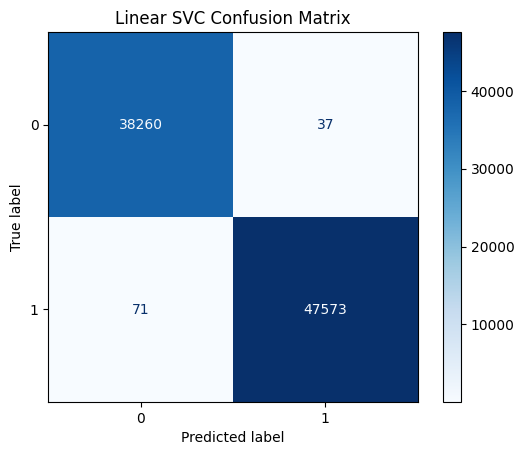

In [8]:
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize model
linear_svc = LinearSVC(dual=False, C=1, max_iter=1000, penalty="l2")

# Measure training time
start_train = time.time()
linear_svc.fit(X_train_pca, y_train)
end_train = time.time()

# Measure prediction time
start_predict = time.time()
y_pred = linear_svc.predict(X_test_pca)
end_predict = time.time()

# Compute total time
total_time = end_predict - start_train

# Print results
print(f"Training Time: {end_train - start_train:.4f} seconds")
print(f"Prediction Time: {end_predict - start_predict:.4f} seconds")
print(f"Total Time: {total_time:.4f} seconds")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Linear SVC Confusion Matrix")
plt.show()


### DecisionTreeClassification

Training Time: 2.1623 seconds
Prediction Time: 0.0039 seconds
Total Time: 2.1662 seconds
Accuracy: 0.9996509233078508
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38297
           1       1.00      1.00      1.00     47644

    accuracy                           1.00     85941
   macro avg       1.00      1.00      1.00     85941
weighted avg       1.00      1.00      1.00     85941



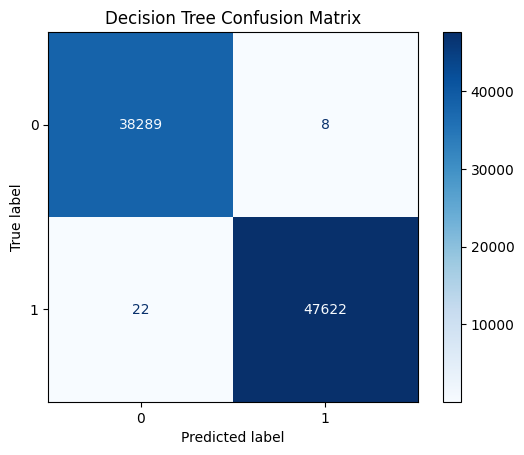

In [9]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='log_loss', max_depth= 14, max_features= None, min_samples_leaf= 8, min_samples_split= 16, splitter= 'best')

start_train = time.time()
decision_tree.fit(X_train_pca, y_train)
end_train = time.time()

# Measure prediction time
start_predict = time.time()
y_pred = decision_tree.predict(X_test_pca)
end_predict = time.time()

# Compute total time
total_time = end_predict - start_train

# Print results
print(f"Training Time: {end_train - start_train:.4f} seconds")
print(f"Prediction Time: {end_predict - start_predict:.4f} seconds")
print(f"Total Time: {total_time:.4f} seconds")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()

### KNN

Training Time: 0.4931 seconds
Prediction Time: 2.0173 seconds
Total Time: 2.5104 seconds
Accuracy: 0.9999069128820935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38297
           1       1.00      1.00      1.00     47644

    accuracy                           1.00     85941
   macro avg       1.00      1.00      1.00     85941
weighted avg       1.00      1.00      1.00     85941

Accuracy: 0.9999069128820935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38297
           1       1.00      1.00      1.00     47644

    accuracy                           1.00     85941
   macro avg       1.00      1.00      1.00     85941
weighted avg       1.00      1.00      1.00     85941



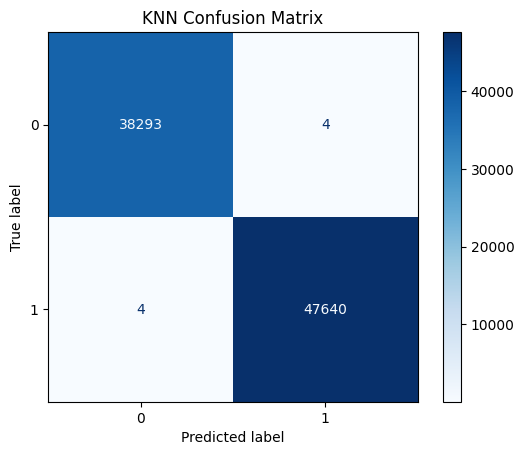

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, p=4, weights='distance')

start_train = time.time()
knn.fit(X_train_pca, y_train)
end_train = time.time()

# Measure prediction time
start_predict = time.time()
y_pred = knn.predict(X_test_pca)
end_predict = time.time()

# Compute total time
total_time = end_predict - start_train

# Print results
print(f"Training Time: {end_train - start_train:.4f} seconds")
print(f"Prediction Time: {end_predict - start_predict:.4f} seconds")
print(f"Total Time: {total_time:.4f} seconds")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix")
plt.show()

### Serialization of trained models

In [12]:
import pickle
with open('../app/ml_model/binary-knn.pkl', 'wb') as file:
    pickle.dump(knn, file)

with open('../app/ml_model/binary-decision-tree.pkl', 'wb') as file:
    pickle.dump(decision_tree, file)

with open('../app/ml_model/binary-linear-svc.pkl', 'wb') as file:
    pickle.dump(linear_svc, file)